### Libraries

In [116]:
import pandas as pd

import numpy as np

import time

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.model_selection import KFold, train_test_split, cross_val_score

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

### Imbalanced data

In [2]:
# Read in data

t0 = time.time()
df = pd.read_csv('aggregate-20160501.csv')
t1 = time.time()
print(str((t1-t0)/60) + " minutes")

6.257964468002319 minutes


In [3]:
#df.head()
#df.shape
#df.columns
#set(df.num_edits)

In [4]:
# Calculate percentage of unedited articles in original imbalanced data

len(df["num_edits"][df["num_edits"] == 0])/len(df["num_edits"])*100

99.91720181519122

In [5]:
# Check missingness in original imbalanced data

print(df.isnull().sum())

article_name                   1
num_edits                      0
views_30d                      0
views_7d                       0
views_3d                       0
views_1d                       0
edits_30d                      0
edits_7d                       0
edits_3d                       0
edits_1d                       0
minor_edits_30d                0
minor_edits_7d                 0
minor_edits_3d                 0
minor_edits_1d                 0
avg_size_30d             6428583
avg_size_7d             45268487
avg_size_3d             49800824
avg_size_1d             53028939
avg_size                  209968
latest_size               209968
talk_views_30d                 0
talk_views_7d                  0
talk_views_3d                  0
talk_views_1d                  0
talk_edits_30d                 0
talk_edits_7d                  0
talk_edits_3d                  0
talk_edits_1d                  0
talk_minor_edits_30d           0
talk_minor_edits_7d            0
talk_minor

In [6]:
# Generate binary edited vs. unedited variable

df['num_edits_binary'] = df['num_edits'].apply(lambda x: int(x > 0))
#set(df['num_edits_binary'])

In [7]:
# Store relevant variable names in a list

feature_names = [x for x in df.columns if 'num_edits' not in x and 'article_name' not in x]

label_name = "num_edits_binary"

feature_names

['views_30d',
 'views_7d',
 'views_3d',
 'views_1d',
 'edits_30d',
 'edits_7d',
 'edits_3d',
 'edits_1d',
 'minor_edits_30d',
 'minor_edits_7d',
 'minor_edits_3d',
 'minor_edits_1d',
 'avg_size_30d',
 'avg_size_7d',
 'avg_size_3d',
 'avg_size_1d',
 'avg_size',
 'latest_size',
 'talk_views_30d',
 'talk_views_7d',
 'talk_views_3d',
 'talk_views_1d',
 'talk_edits_30d',
 'talk_edits_7d',
 'talk_edits_3d',
 'talk_edits_1d',
 'talk_minor_edits_30d',
 'talk_minor_edits_7d',
 'talk_minor_edits_3d',
 'talk_minor_edits_1d',
 'talk_avg_size_30d',
 'talk_avg_size_7d',
 'talk_avg_size_3d',
 'talk_avg_size_1d',
 'talk_avg_size',
 'talk_latest_size']

### Balanced data

In [8]:
## Generate balanced sample

t0 = time.time()

np.random.seed(seed=13579)

# to be set aside as imbalanced test data
set1_idx = np.random.choice(range(len(df)), int(len(df) * .2), replace=False)
set1_X = df.loc[set1_idx, feature_names]
set1_Y = df.loc[set1_idx, label_name]

# to be used to generate balanced data for main analysis
set2_idx = list(set(range(len(df))) - set(list(set1_idx)))
set2 = df.loc[set2_idx, list(df.columns.tolist())]

edited = set2[set2.num_edits > 0.0].copy(deep=True)
#edited.shape

not_edited = set2[set2.num_edits == 0.0].copy(deep=True)

not_edited_selected = not_edited[0:edited.shape[0]]

balanced_set = pd.concat([edited, not_edited_selected])

balanced_set = shuffle(balanced_set)
#balanced_set.shape

t1 = time.time()
print(str((t1-t0)/60) + " minutes")

4.955658749739329 minutes


In [9]:
print(edited.shape)
print(balanced_set.shape)

(41624, 39)
(83248, 39)


In [10]:
# Write balanced data to csv

balanced_set.to_csv('balanced_set_20160501.csv', sep=',')
#balanced_set.head()

In [2]:
# Read in balanced data

df_b = pd.read_csv('balanced_set_20160501.csv')
df_b = df_b.set_index('Unnamed: 0')
df_b.index.name = None
#df_b.head()

In [3]:
# Calculate percentage of unedited articles in balanced data

len(df_b["num_edits_binary"][df_b["num_edits_binary"] == 0])/len(df_b["num_edits_binary"])*100

50.0

In [4]:
# Check missingness in balanced data

print(df_b.isnull().sum())

article_name                0
num_edits                   0
views_30d                   0
views_7d                    0
views_3d                    0
views_1d                    0
edits_30d                   0
edits_7d                    0
edits_3d                    0
edits_1d                    0
minor_edits_30d             0
minor_edits_7d              0
minor_edits_3d              0
minor_edits_1d              0
avg_size_30d              496
avg_size_7d              7505
avg_size_3d              9725
avg_size_1d             10885
avg_size                    1
latest_size                 1
talk_views_30d              0
talk_views_7d               0
talk_views_3d               0
talk_views_1d               0
talk_edits_30d              0
talk_edits_7d               0
talk_edits_3d               0
talk_edits_1d               0
talk_minor_edits_30d        0
talk_minor_edits_7d         0
talk_minor_edits_3d         0
talk_minor_edits_1d         0
talk_avg_size_30d       17892
talk_avg_s

### New Features

In [5]:
# Generate features

# Views

df_b['total_views'] = df_b.views_1d + df_b.views_3d + df_b.views_7d + df_b.views_30d

# Version 1

df_b['change_in_views_v1_7_30'] = df_b.views_7d/4 - df_b.views_30d/23

df_b['change_in_views_v1_3_7'] = df_b.views_3d/2 - df_b.views_7d/4 

df_b['change_in_views_v1_1_3'] = df_b.views_1d/1 - df_b.views_3d/2

# Version 2

df_b['change_in_views_v2_7_30'] = ((df_b.views_7d/4)+1)/((df_b.views_30d/23)+1)

df_b['change_in_views_v2_3_7'] = ((df_b.views_3d/2)+1)/((df_b.views_7d/4)+1)

df_b['change_in_views_v2_1_3'] = ((df_b.views_1d/1)+1)/((df_b.views_3d/2)+1)

#df_b['total_views'].describe()

In [6]:
# Edits

df_b['total_edits'] = df_b.edits_1d + df_b.edits_3d + df_b.edits_7d + df_b.edits_30d

# Version 1

df_b['change_in_edits_v1_7_30'] = df_b.edits_7d/4 - df_b.edits_30d/23

df_b['change_in_edits_v1_3_7'] = df_b.edits_3d/2 - df_b.edits_7d/4

df_b['change_in_edits_v1_1_3'] = df_b.edits_1d/1 - df_b.edits_3d/2

# Version 2

df_b['change_in_edits_v2_7_30'] = ((df_b.edits_7d/4)+1)/((df_b.edits_30d/23)+1)

df_b['change_in_edits_v2_3_7'] = ((df_b.edits_3d/2)+1)/((df_b.edits_7d/4)+1)

df_b['change_in_edits_v2_1_3'] = ((df_b.edits_1d/1)+1)/((df_b.edits_3d/2)+1)

#df_b['total_edits'].describe()

In [7]:
# Minor edits

df_b['total_minor_edits'] = df_b.minor_edits_1d + df_b.minor_edits_3d + df_b.minor_edits_7d + df_b.minor_edits_30d

# Version 1

df_b['change_in_minor_edits_v1_7_30'] = df_b.minor_edits_7d/4 - df_b.minor_edits_30d/23

df_b['change_in_minor_edits_v1_3_7'] = df_b.minor_edits_3d/2 - df_b.minor_edits_7d/4

df_b['change_in_minor_edits_v1_1_3'] = df_b.minor_edits_1d/1 - df_b.minor_edits_3d/2

# Version 2

df_b['change_in_minor_edits_v2_7_30'] = ((df_b.minor_edits_7d/4)+1)/((df_b.minor_edits_30d/23)+1)

df_b['change_in_minor_edits_v2_3_7'] = ((df_b.minor_edits_3d/2)+1)/((df_b.minor_edits_7d/4)+1)

df_b['change_in_minor_edits_v2_1_3'] = ((df_b.minor_edits_1d/1)+1)/((df_b.minor_edits_3d/2)+1)

#df_b['total_minor_edits'].describe()

In [8]:
# Average size

# Version 1

df_b['change_in_avg_size_v1_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (x['avg_size_7d']/4 - x['avg_size_30d']/23), 
    axis=1
)

df_b['change_in_avg_size_v1_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (x['avg_size_3d']/2 - x['avg_size_7d']/4), 
    axis=1
)

df_b['change_in_avg_size_v1_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (x['avg_size_1d']/1 - x['avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_avg_size_v2_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (((x['avg_size_7d']/4)+1)/((x['avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (((x['avg_size_3d']/2)+1)/((x['avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (((x['avg_size_1d']/1)+1)/((x['avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_avg_size_v2_1_3'].describe()

In [9]:
# Talk views

df_b['total_talk_views'] = df_b.talk_views_1d + df_b.talk_views_3d + df_b.talk_views_7d + df_b.talk_views_30d

# Version 1

df_b['change_in_talk_views_v1_7_30'] = df_b.talk_views_7d/4 - df_b.talk_views_30d/23

df_b['change_in_talk_views_v1_3_7'] = df_b.talk_views_3d/2 - df_b.talk_views_7d/4 

df_b['change_in_talk_views_v1_1_3'] = df_b.talk_views_1d/1 - df_b.talk_views_3d/2

# Version 2

df_b['change_in_talk_views_v2_7_30'] = ((df_b.talk_views_7d/4)+1)/((df_b.talk_views_30d/23)+1)

df_b['change_in_talk_views_v2_3_7'] = ((df_b.talk_views_3d/2)+1)/((df_b.talk_views_7d/4)+1)

df_b['change_in_talk_views_v2_1_3'] = ((df_b.talk_views_1d/1)+1)/((df_b.talk_views_3d/2)+1)

#df_b['total_talk_views'].describe()

In [10]:
# Talk edits

df_b['total_talk_edits'] = df_b.talk_edits_1d + df_b.talk_edits_3d + df_b.talk_edits_7d + df_b.talk_edits_30d

# Version 1

df_b['change_in_talk_edits_v1_7_30'] = df_b.talk_edits_7d/4 - df_b.talk_edits_30d/23

df_b['change_in_talk_edits_v1_3_7'] = df_b.talk_edits_3d/2 - df_b.talk_edits_7d/4

df_b['change_in_talk_edits_v1_1_3'] = df_b.talk_edits_1d/1 - df_b.talk_edits_3d/2

# Version 2

df_b['change_in_talk_edits_v2_7_30'] = ((df_b.talk_edits_7d/4)+1)/((df_b.talk_edits_30d/23)+1)

df_b['change_in_talk_edits_v2_3_7'] = ((df_b.talk_edits_3d/2)+1)/((df_b.talk_edits_7d/4)+1)

df_b['change_in_talk_edits_v2_1_3'] = ((df_b.talk_edits_1d/1)+1)/((df_b.talk_edits_3d/2)+1)

#df_b['total_talk_edits'].describe()

In [11]:
# Talk minor edits

df_b['total_talk_minor_edits'] = (df_b.talk_minor_edits_1d + df_b.talk_minor_edits_3d + 
                                  df_b.talk_minor_edits_7d + df_b.talk_minor_edits_30d)


# Version 1

df_b['change_in_talk_minor_edits_v1_7_30'] = df_b.talk_minor_edits_7d/4 - df_b.talk_minor_edits_30d/23

df_b['change_in_talk_minor_edits_v1_3_7'] = df_b.talk_minor_edits_3d/2 - df_b.talk_minor_edits_7d/4

df_b['change_in_talk_minor_edits_v1_1_3'] = df_b.talk_minor_edits_1d/1 - df_b.talk_minor_edits_3d/2

# Version 2

df_b['change_in_talk_minor_edits_v2_7_30'] = ((df_b.talk_minor_edits_7d/4)+1)/((df_b.talk_minor_edits_30d/23)+1)

df_b['change_in_talk_minor_edits_v2_3_7'] = ((df_b.talk_minor_edits_3d/2)+1)/((df_b.talk_minor_edits_7d/4)+1)

df_b['change_in_talk_minor_edits_v2_1_3'] = ((df_b.talk_minor_edits_1d/1)+1)/((df_b.talk_minor_edits_3d/2)+1)

#df_b['total_talk_minor_edits'].describe()

In [12]:
# Talk average size

# Version 1

df_b['change_in_talk_avg_size_v1_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (x['talk_avg_size_7d']/4 - x['talk_avg_size_30d']/23), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (x['talk_avg_size_3d']/2 - x['talk_avg_size_7d']/4), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (x['talk_avg_size_1d']/1 - x['talk_avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_talk_avg_size_v2_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (((x['talk_avg_size_7d']/4)+1)/((x['talk_avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (((x['talk_avg_size_3d']/2)+1)/((x['talk_avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (((x['talk_avg_size_1d']/1)+1)/((x['talk_avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_talk_avg_size_v2_1_3'].describe()

In [13]:
# Check missingness in balanced data with new features

print(df_b.isnull().sum())

article_name                              0
num_edits                                 0
views_30d                                 0
views_7d                                  0
views_3d                                  0
views_1d                                  0
edits_30d                                 0
edits_7d                                  0
edits_3d                                  0
edits_1d                                  0
minor_edits_30d                           0
minor_edits_7d                            0
minor_edits_3d                            0
minor_edits_1d                            0
avg_size_30d                            496
avg_size_7d                            7505
avg_size_3d                            9725
avg_size_1d                           10885
avg_size                                  1
latest_size                               1
talk_views_30d                            0
talk_views_7d                             0
talk_views_3d                   

In [14]:
# Write balanced data (with new features) to csv

df_b.to_csv('balanced_set2_20160501.csv', sep=',')
#df_b.head()

In [117]:
# Read in balanced data (with new features)

df_b2 = pd.read_csv('balanced_set2_20160501.csv')
df_b2 = df_b2.set_index('Unnamed: 0')
df_b2.index.name = None
print(df_b2.shape)
#df_b2.head()

(83248, 93)


In [118]:
df_b2_ri = df_b2.reset_index()
df_b2_ri = df_b2_ri.rename(columns={'index': 'original_index'})
df_b2_ri.shape
#df_b2_ri.head()

(83248, 94)

In [119]:
# Store relevant variable names (including new features) in a list

new_feature_names = [x for x in df_b2_ri.columns 
                     if 'original_index' not in x
                     and 'article_name' not in x
                     and 'num_edits' not in x
                     and 'views_30d' not in x
                     and 'views_7d' not in x
                     and 'views_3d' not in x
                     and 'views_1d' not in x
                     and 'edits_30d' not in x
                     and 'edits_7d' not in x
                     and 'edits_3d' not in x
                     and 'edits_1d' not in x
                     and 'minor_edits_30d' not in x
                     and 'minor_edits_7d' not in x
                     and 'minor_edits_3d' not in x
                     and 'minor_edits_1d' not in x
                     and 'avg_size_30d' not in x
                     and 'avg_size_7d' not in x
                     and 'avg_size_3d' not in x
                     and 'avg_size_1d' not in x
                     and 'talk_views_30d' not in x
                     and 'talk_views_7d' not in x
                     and 'talk_views_3d' not in x
                     and 'talk_views_1d' not in x
                     and 'talk_edits_30d' not in x
                     and 'talk_edits_7d' not in x
                     and 'talk_edits_3d' not in x
                     and 'talk_edits_1d' not in x
                     and 'talk_minor_edits_30d' not in x
                     and 'talk_minor_edits_7d' not in x
                     and 'talk_minor_edits_3d' not in x
                     and 'talk_minor_edits_1d' not in x
                     and 'talk_avg_size_30d' not in x
                     and 'talk_avg_size_7d' not in x
                     and 'talk_avg_size_3d' not in x
                     and 'talk_avg_size_1d' not in x
                     and 'talk_avg_size' not in x
                     and 'talk_latest_size' not in x]

print(len(new_feature_names))

label_name = "num_edits_binary"

50


In [120]:
# Drop rows with NaN's 

df_b2_ri = df_b2_ri[new_feature_names + [label_name]]
df_b2_ri = df_b2_ri.dropna() 

df_b2_ri = df_b2_ri.reset_index()
df_b2_ri = df_b2_ri.drop('index', 1)

print(df_b2_ri.shape)
#df_b2_ri.head()

(82461, 51)


In [121]:
df_b2_ri.isnull().sum()

avg_size                              0
latest_size                           0
total_views                           0
change_in_views_v1_7_30               0
change_in_views_v1_3_7                0
change_in_views_v1_1_3                0
change_in_views_v2_7_30               0
change_in_views_v2_3_7                0
change_in_views_v2_1_3                0
total_edits                           0
change_in_edits_v1_7_30               0
change_in_edits_v1_3_7                0
change_in_edits_v1_1_3                0
change_in_edits_v2_7_30               0
change_in_edits_v2_3_7                0
change_in_edits_v2_1_3                0
total_minor_edits                     0
change_in_minor_edits_v1_7_30         0
change_in_minor_edits_v1_3_7          0
change_in_minor_edits_v1_1_3          0
change_in_minor_edits_v2_7_30         0
change_in_minor_edits_v2_3_7          0
change_in_minor_edits_v2_1_3          0
change_in_avg_size_v1_7_30            0
change_in_avg_size_v1_3_7             0


In [122]:
print(len(df_b2_ri[df_b2_ri.num_edits_binary == 0])) # number of unedited articles
print(len(df_b2_ri[df_b2_ri.num_edits_binary != 0])) # number of edited articles

41613
40848


In [123]:
# Normalize features

def normalize(raw_data):
    mean = np.mean(raw_data)
    sd = np.std(raw_data)
    normalized_data = (raw_data-mean)/sd
    return normalized_data

In [151]:
features = list(set(df_b2_ri.columns.tolist()) - set(['num_edits_binary']))

df_b2_ri_n = df_b2_ri.copy(deep=True)

for f in features:
    df_b2_ri_n[f] = normalize(df_b2_ri_n[f])
    
#df_b2_ri_n.head()

In [152]:
# Convert data frame to matrix

X = df_b2_ri_n[new_feature_names].as_matrix()
X_nn = df_b2_ri[new_feature_names].as_matrix()

Y = df_b2_ri_n[label_name].as_matrix()
Y_nn = df_b2_ri[label_name].as_matrix()

### Correlation matrix

In [153]:
corr_table = df_b2_ri_n[[label_name] + new_feature_names].corr(method='pearson')
corr_table.style.background_gradient(cmap='RdYlGn', axis = 0)

### Models

In [14]:
# Logistic regression

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit_test_acc = []
logit_test_precision = []
logit_test_recall = []
logit_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    logit = LogisticRegression()
    logit.fit(train_x, train_y)
    
    y_pred_test = logit.predict(test_x)
    
    logit_test_acc += [accuracy_score(test_y, y_pred_test)]
    logit_test_precision += [precision_score(test_y, y_pred_test)]
    logit_test_recall += [recall_score(test_y, y_pred_test)]
    logit_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
logit_time_taken = t1-t0

print("Time taken is: " + str(logit_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(logit_test_acc)))
print("Test precision is: " + str(np.mean(logit_test_precision)))
print("Test recall is: " + str(np.mean(logit_test_recall)))
print("Test ROC AUC is: " + str(np.mean(logit_test_roc_auc)))

Time taken is: 0.6305030504862468 minutes
Test accuracy is: 0.680624796041
Test precision is: 0.773976391671
Test recall is: 0.501856603344
Test ROC AUC is: 0.678991733708


In [15]:
# Decision tree

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tree_test_acc = []
tree_test_precision = []
tree_test_recall = []
tree_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tree = DecisionTreeClassifier(random_state=13579, max_depth=4)
    tree.fit(train_x, train_y)
    
    y_pred_test = tree.predict(test_x)
    
    tree_test_acc += [accuracy_score(test_y, y_pred_test)]
    tree_test_precision += [precision_score(test_y, y_pred_test)]
    tree_test_recall += [recall_score(test_y, y_pred_test)]
    tree_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tree_time_taken = t1-t0

print("Time taken is: " + str(tree_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tree_test_acc)))
print("Test precision is: " + str(np.mean(tree_test_precision)))
print("Test recall is: " + str(np.mean(tree_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tree_test_roc_auc)))

Time taken is: 0.030067086219787598 minutes
Test accuracy is: 0.739901277987
Test precision is: 0.767492580959
Test recall is: 0.681386973861
Test ROC AUC is: 0.739378889227


In [16]:
# LASSO

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

lasso_test_acc = []
lasso_test_precision = []
lasso_test_recall = []
lasso_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    lasso = LogisticRegression(penalty = 'l1')
    lasso.fit(train_x, train_y)
    
    y_pred_test = lasso.predict(test_x)
    
    lasso_test_acc += [accuracy_score(test_y, y_pred_test)]
    lasso_test_precision += [precision_score(test_y, y_pred_test)]
    lasso_test_recall += [recall_score(test_y, y_pred_test)]
    lasso_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
lasso_time_taken = t1-t0

print("Time taken is: " + str(lasso_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(lasso_test_acc)))
print("Test precision is: " + str(np.mean(lasso_test_precision)))
print("Test recall is: " + str(np.mean(lasso_test_recall)))
print("Test ROC AUC is: " + str(np.mean(lasso_test_roc_auc)))

Time taken is: 0.9531628648440044 minutes
Test accuracy is: 0.657801933302
Test precision is: 0.793093538566
Test recall is: 0.419428346196
Test ROC AUC is: 0.655460845702


In [18]:
# K-nearest neighbors

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

knn_test_acc = []
knn_test_precision = []
knn_test_recall = []
knn_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    knn = KNeighborsClassifier()
    knn.fit(train_x, train_y)
    
    y_pred_test = knn.predict(test_x)
    
    knn_test_acc += [accuracy_score(test_y, y_pred_test)]
    knn_test_precision += [precision_score(test_y, y_pred_test)]
    knn_test_recall += [recall_score(test_y, y_pred_test)]
    knn_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
knn_time_taken = t1-t0
    
print("Time taken is: " + str(knn_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(knn_test_acc)))
print("Test precision is: " + str(np.mean(knn_test_precision)))
print("Test recall is: " + str(np.mean(knn_test_recall)))
print("Test ROC AUC is: " + str(np.mean(knn_test_roc_auc)))

Time taken is: 2.808745531241099 minutes
Test accuracy is: 0.680442872015
Test precision is: 0.685845591279
Test recall is: 0.654834635854
Test ROC AUC is: 0.680204874902


In [178]:
# Random forest

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

forest_test_acc = []
forest_test_precision = []
forest_test_recall = []
forest_test_roc_auc = []


t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    forest = RandomForestClassifier(random_state=13579, max_depth=4)
    forest.fit(train_x, train_y)
    
    y_pred_test = forest.predict(test_x)
    
    forest_test_acc += [accuracy_score(test_y, y_pred_test)]
    forest_test_precision += [precision_score(test_y, y_pred_test)]
    forest_test_recall += [recall_score(test_y, y_pred_test)]
    forest_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

    
t1 = time.time()
forest_time_taken = t1-t0

print("Time taken is: " + str(forest_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(forest_test_acc)))
print("Test precision is: " + str(np.mean(forest_test_precision)))
print("Test recall is: " + str(np.mean(forest_test_recall)))
print("Test ROC AUC is: " + str(np.mean(forest_test_roc_auc)))

Time taken is: 0.05601060390472412 minutes
Test accuracy is: 0.697420774237
Test precision is: 0.770259887518
Test recall is: 0.554264438489
Test ROC AUC is: 0.696128638156


In [24]:
# Multi-layer perceptron

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tron_test_acc = []
tron_test_precision = []
tron_test_recall = []
tron_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tron = MLPClassifier(solver='lbfgs', random_state=13579)
    tron.fit(train_x, train_y)
    
    y_pred_test = tron.predict(test_x)
    
    tron_test_acc += [accuracy_score(test_y, y_pred_test)]
    tron_test_precision += [precision_score(test_y, y_pred_test)]
    tron_test_recall += [recall_score(test_y, y_pred_test)]
    tron_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tron_time_taken = t1-t0

print("Time taken is: " + str(tron_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tron_test_acc)))
print("Test precision is: " + str(np.mean(tron_test_precision)))
print("Test recall is: " + str(np.mean(tron_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tron_test_roc_auc)))

Time taken is: 2.535447363058726 minutes
Test accuracy is: 0.760444313619
Test precision is: 0.770711375737
Test recall is: 0.735168453084
Test ROC AUC is: 0.760233571196


In [177]:
# Gradient boosting

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

boost_test_acc = []
boost_test_precision = []
boost_test_recall = []
boost_test_roc_auc = []


t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    

    boost = GradientBoostingClassifier(random_state=13579)
    boost.fit(train_x, train_y)
    
    y_pred_test = boost.predict(test_x)
    
    boost_test_acc += [accuracy_score(test_y, y_pred_test)]
    boost_test_precision += [precision_score(test_y, y_pred_test)]
    boost_test_recall += [recall_score(test_y, y_pred_test)]
    boost_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]



t1 = time.time()
boost_time_taken = t1-t0

print("Time taken is: " + str(boost_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(boost_test_acc)))
print("Test precision is: " + str(np.mean(boost_test_precision)))
print("Test recall is: " + str(np.mean(boost_test_recall)))
print("Test ROC AUC is: " + str(np.mean(boost_test_roc_auc)))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [135]:
# Ensemble learner

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit = LogisticRegression()
tree = DecisionTreeClassifier(random_state=13579, max_depth = 4)
lasso = LogisticRegression(penalty = 'l1')
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=13579, max_depth = 4)
tron = MLPClassifier(solver='lbfgs', random_state=13579)
boost = GradientBoostingClassifier(random_state=13579)

mv_model = VotingClassifier([('logit', logit), 
                             ('tree', tree), 
                             ('lasso', lasso),
                             ('knn', knn),
                             ('forest', forest),
                             ('tron', tron),
                             ('boost', boost)], voting='soft')

mv_model_test_acc = []
mv_model_test_precision = []
mv_model_test_recall = []
mv_model_test_roc_auc = []
tn_fp_fn_tp = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    mv_model.fit(train_x, train_y)
    
    y_pred_test = mv_model.predict(test_x)
    
    mv_model_test_acc += [accuracy_score(test_y, y_pred_test)]
    mv_model_test_precision += [precision_score(test_y, y_pred_test)]
    mv_model_test_recall += [recall_score(test_y, y_pred_test)]
    mv_model_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    tn_fp_fn_tp.append(confusion_matrix(test_y, y_pred_test).ravel())
    
t1 = time.time()
mv_model_time_taken = t1-t0
    
confusion_string = (np.sum(tn_fp_fn_tp, axis=0))

print("Time taken is: " + str(mv_model_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(mv_model_test_acc)))
print("Test precision is: " + str(np.mean(mv_model_test_precision)))
print("Test recall is: " + str(np.mean(mv_model_test_recall)))
print("Test ROC AUC is: " + str(np.mean(mv_model_test_roc_auc)))
#print("TN, FP, FN, TP: " + str(confusion_string))

Time taken is: 16.013201042016348 minutes
Test accuracy is: 0.755666293077
Test precision is: 0.802395710512
Test recall is: 0.672410032374
Test ROC AUC is: 0.754934076166
TN, FP, FN, TP: [34849  6764 13384 27464]


In [136]:
''' TP, FP
    FN, TN'''

array = np.zeros((2,2))
array[0,0] = confusion_string[-1]
array[0,1] = confusion_string[1]
array[1,0] = confusion_string[2]
array[1,1] = confusion_string[0]



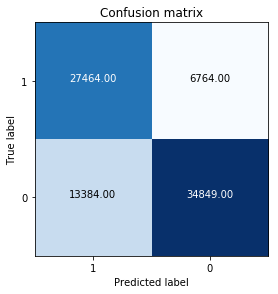

In [143]:

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(matrix, title, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)


plot_confusion_matrix(array, 'Confusion matrix', [1,0])

plt.show()

### Feature importances

In [27]:
# Split balanced data into 0.8 train and 0.2 test

np.random.seed(seed=13579)

train_idx = np.random.choice(range(len(df_b2_ri_n)), int(len(df_b2_ri_n) * .8), replace=False)
test_idx = list(set(range(len(df_b2_ri_n))) - set(list(train_idx)))

train_x = df_b2_ri_n.loc[train_idx, features]
train_y = df_b2_ri_n.loc[train_idx, 'num_edits_binary']
test_x = df_b2_ri_n.loc[test_idx, features]
test_y = df_b2_ri_n.loc[test_idx, 'num_edits_binary']

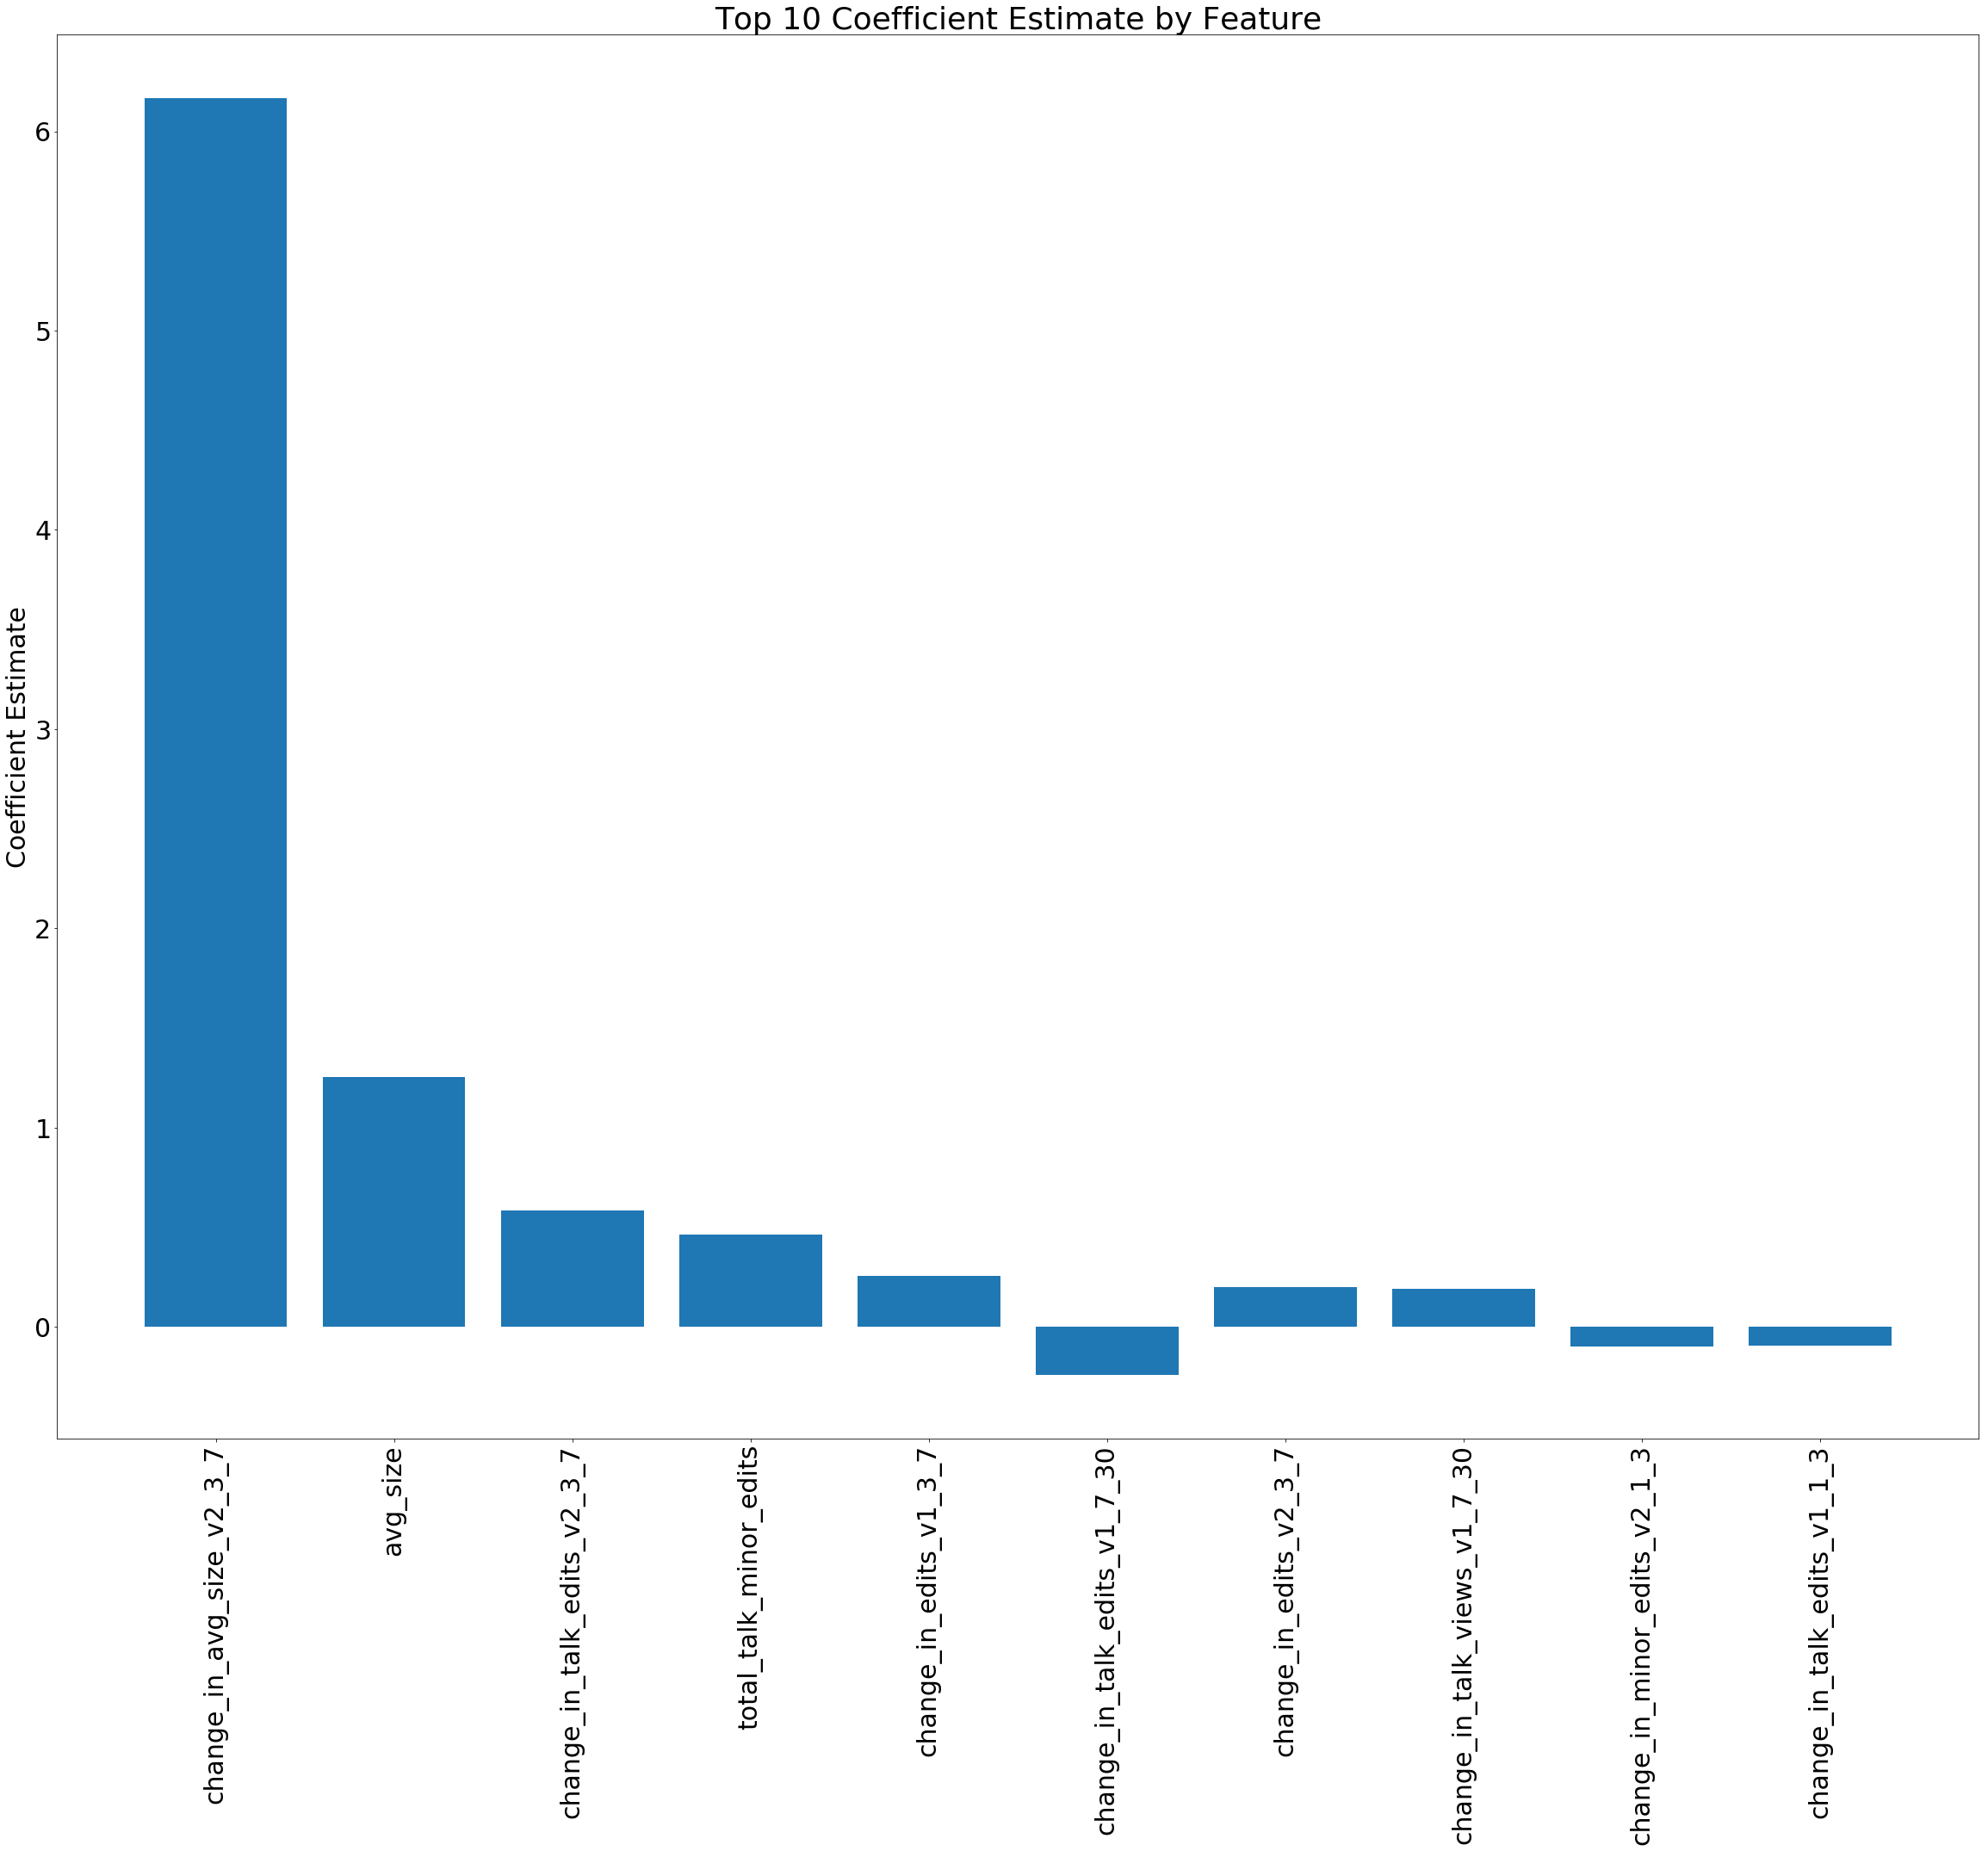

In [59]:
# Logistic regression

logit = LogisticRegression()
logit.fit(train_x, train_y)

logit_coefficients = logit.coef_

plot_lim = 10
ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(np.abs(logit_coefficients[0]), range(plot_lim)), reverse=True)))
coefs = [logit_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 30})

plt.show()

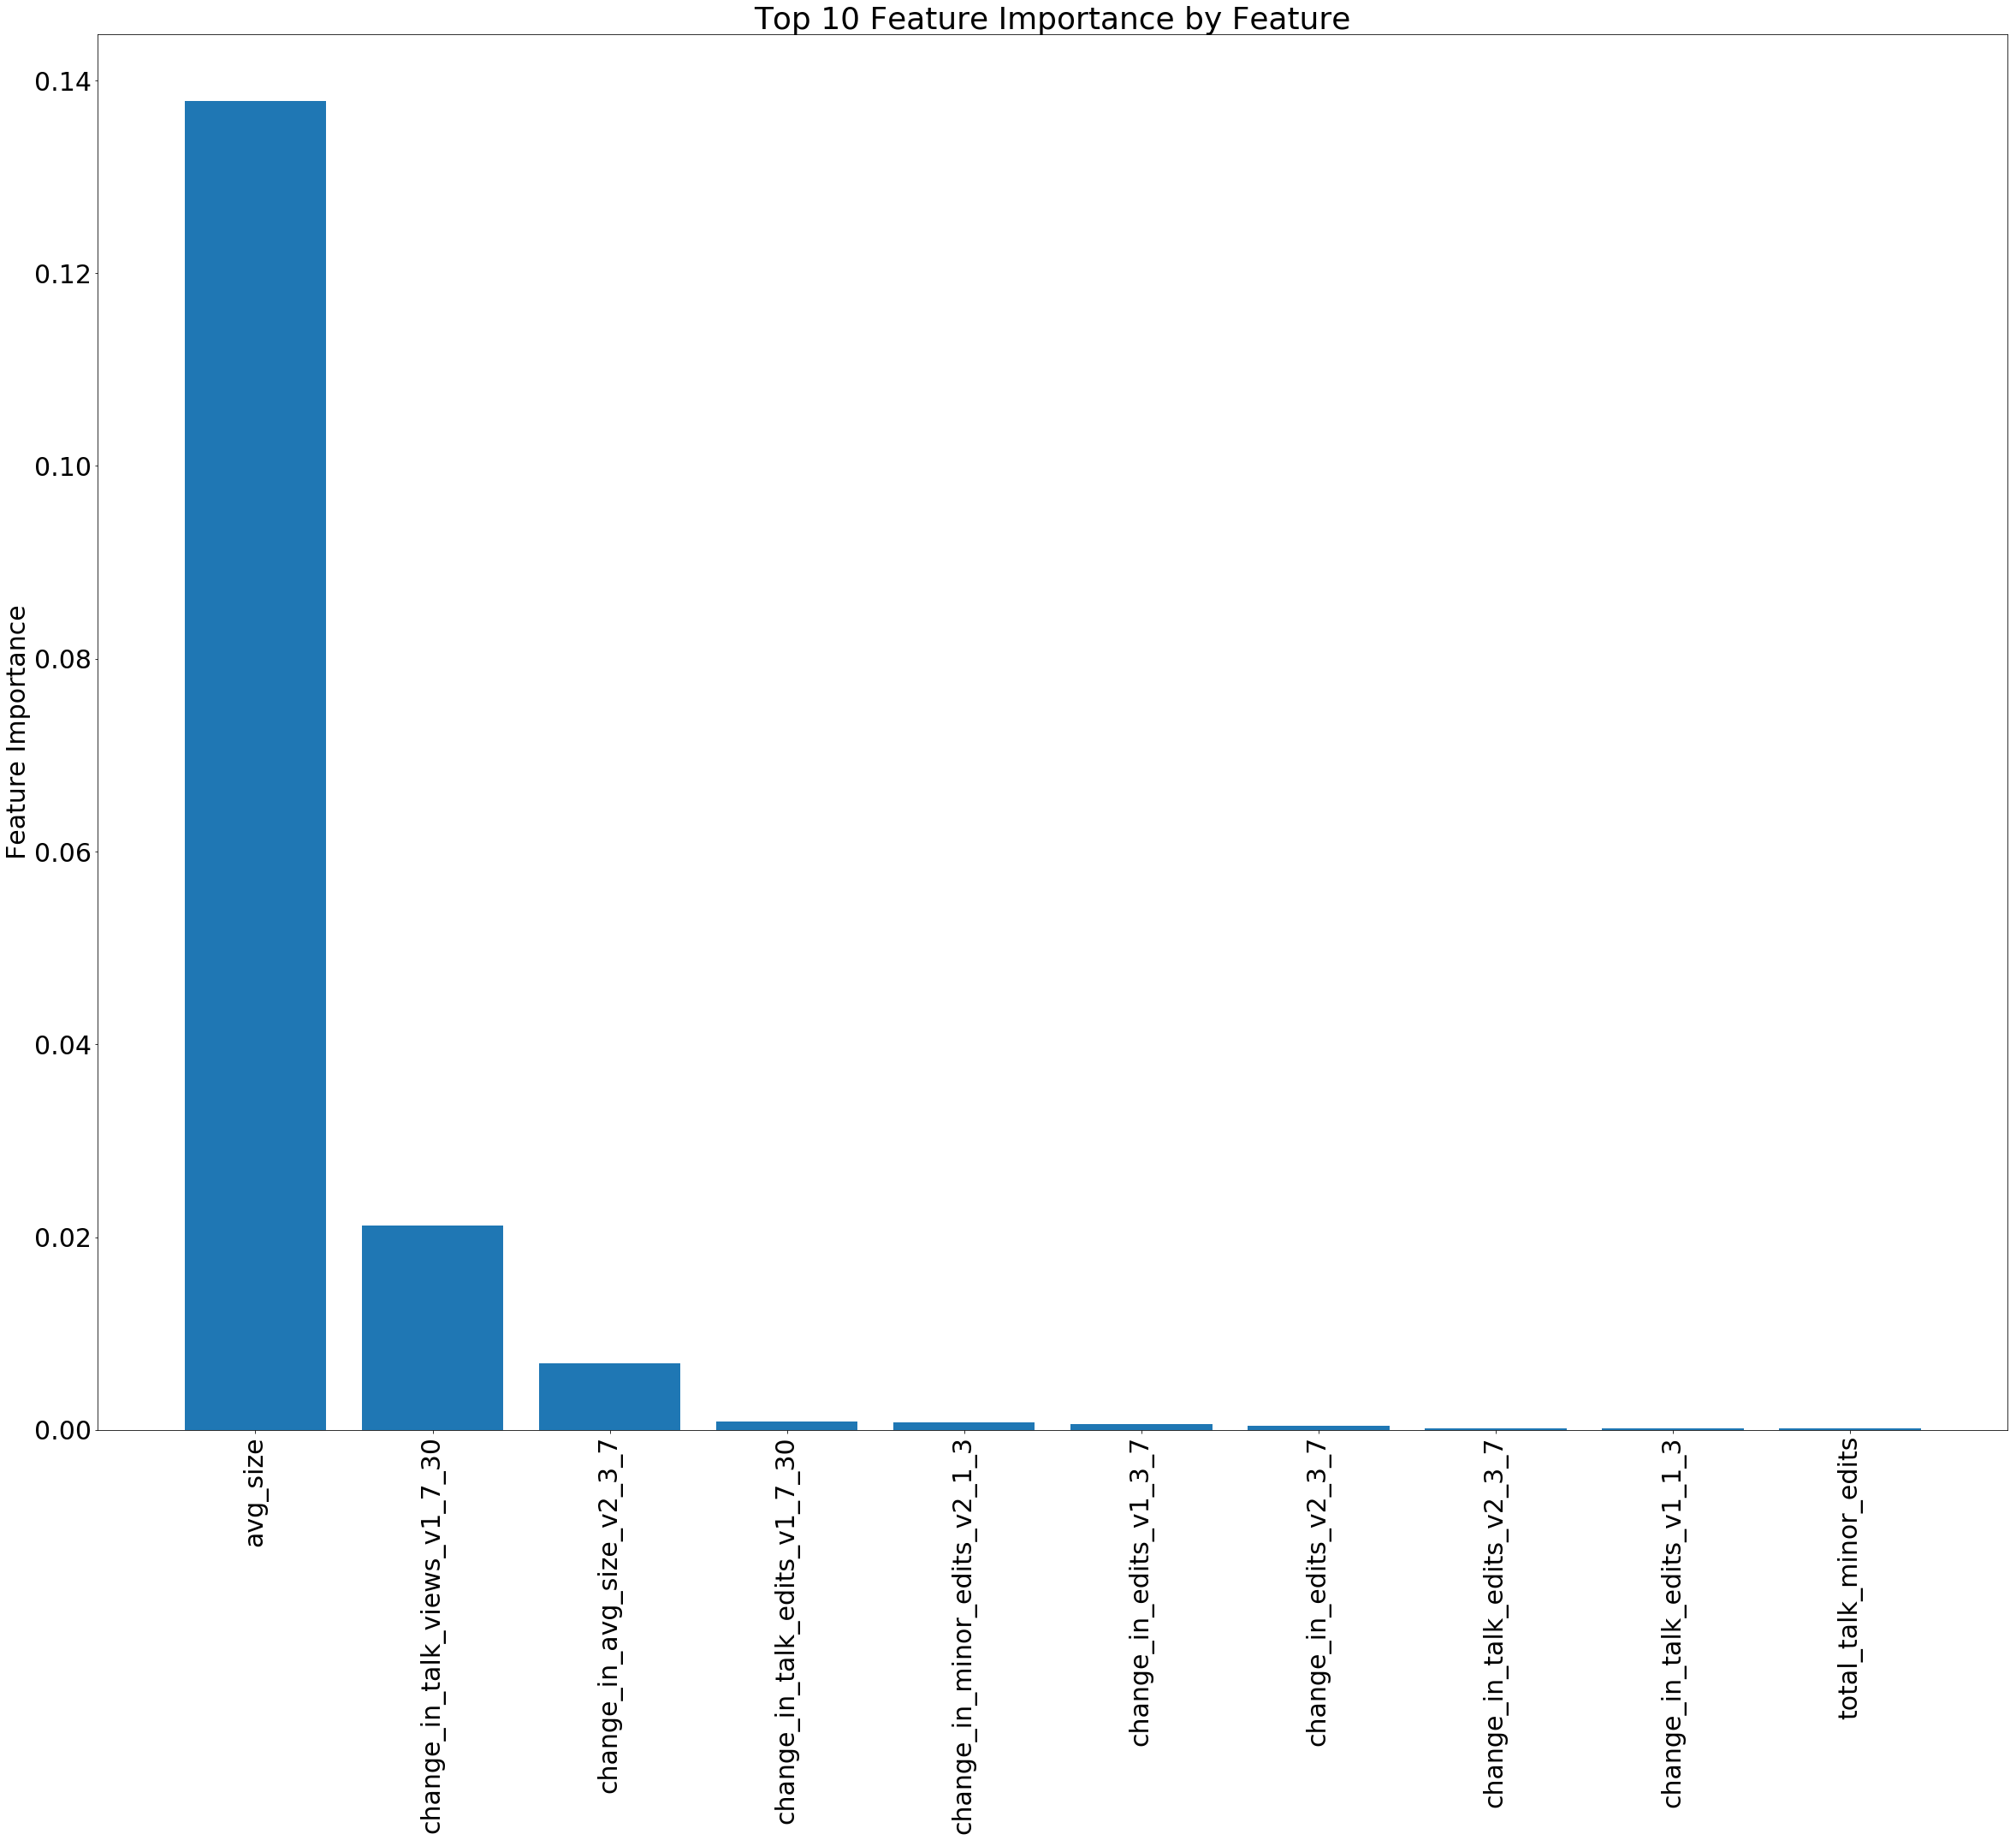

In [60]:
# Decision tree

tree = DecisionTreeClassifier(random_state=13579)
tree.fit(train_x, train_y)

feature_importances = tree.feature_importances_

ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

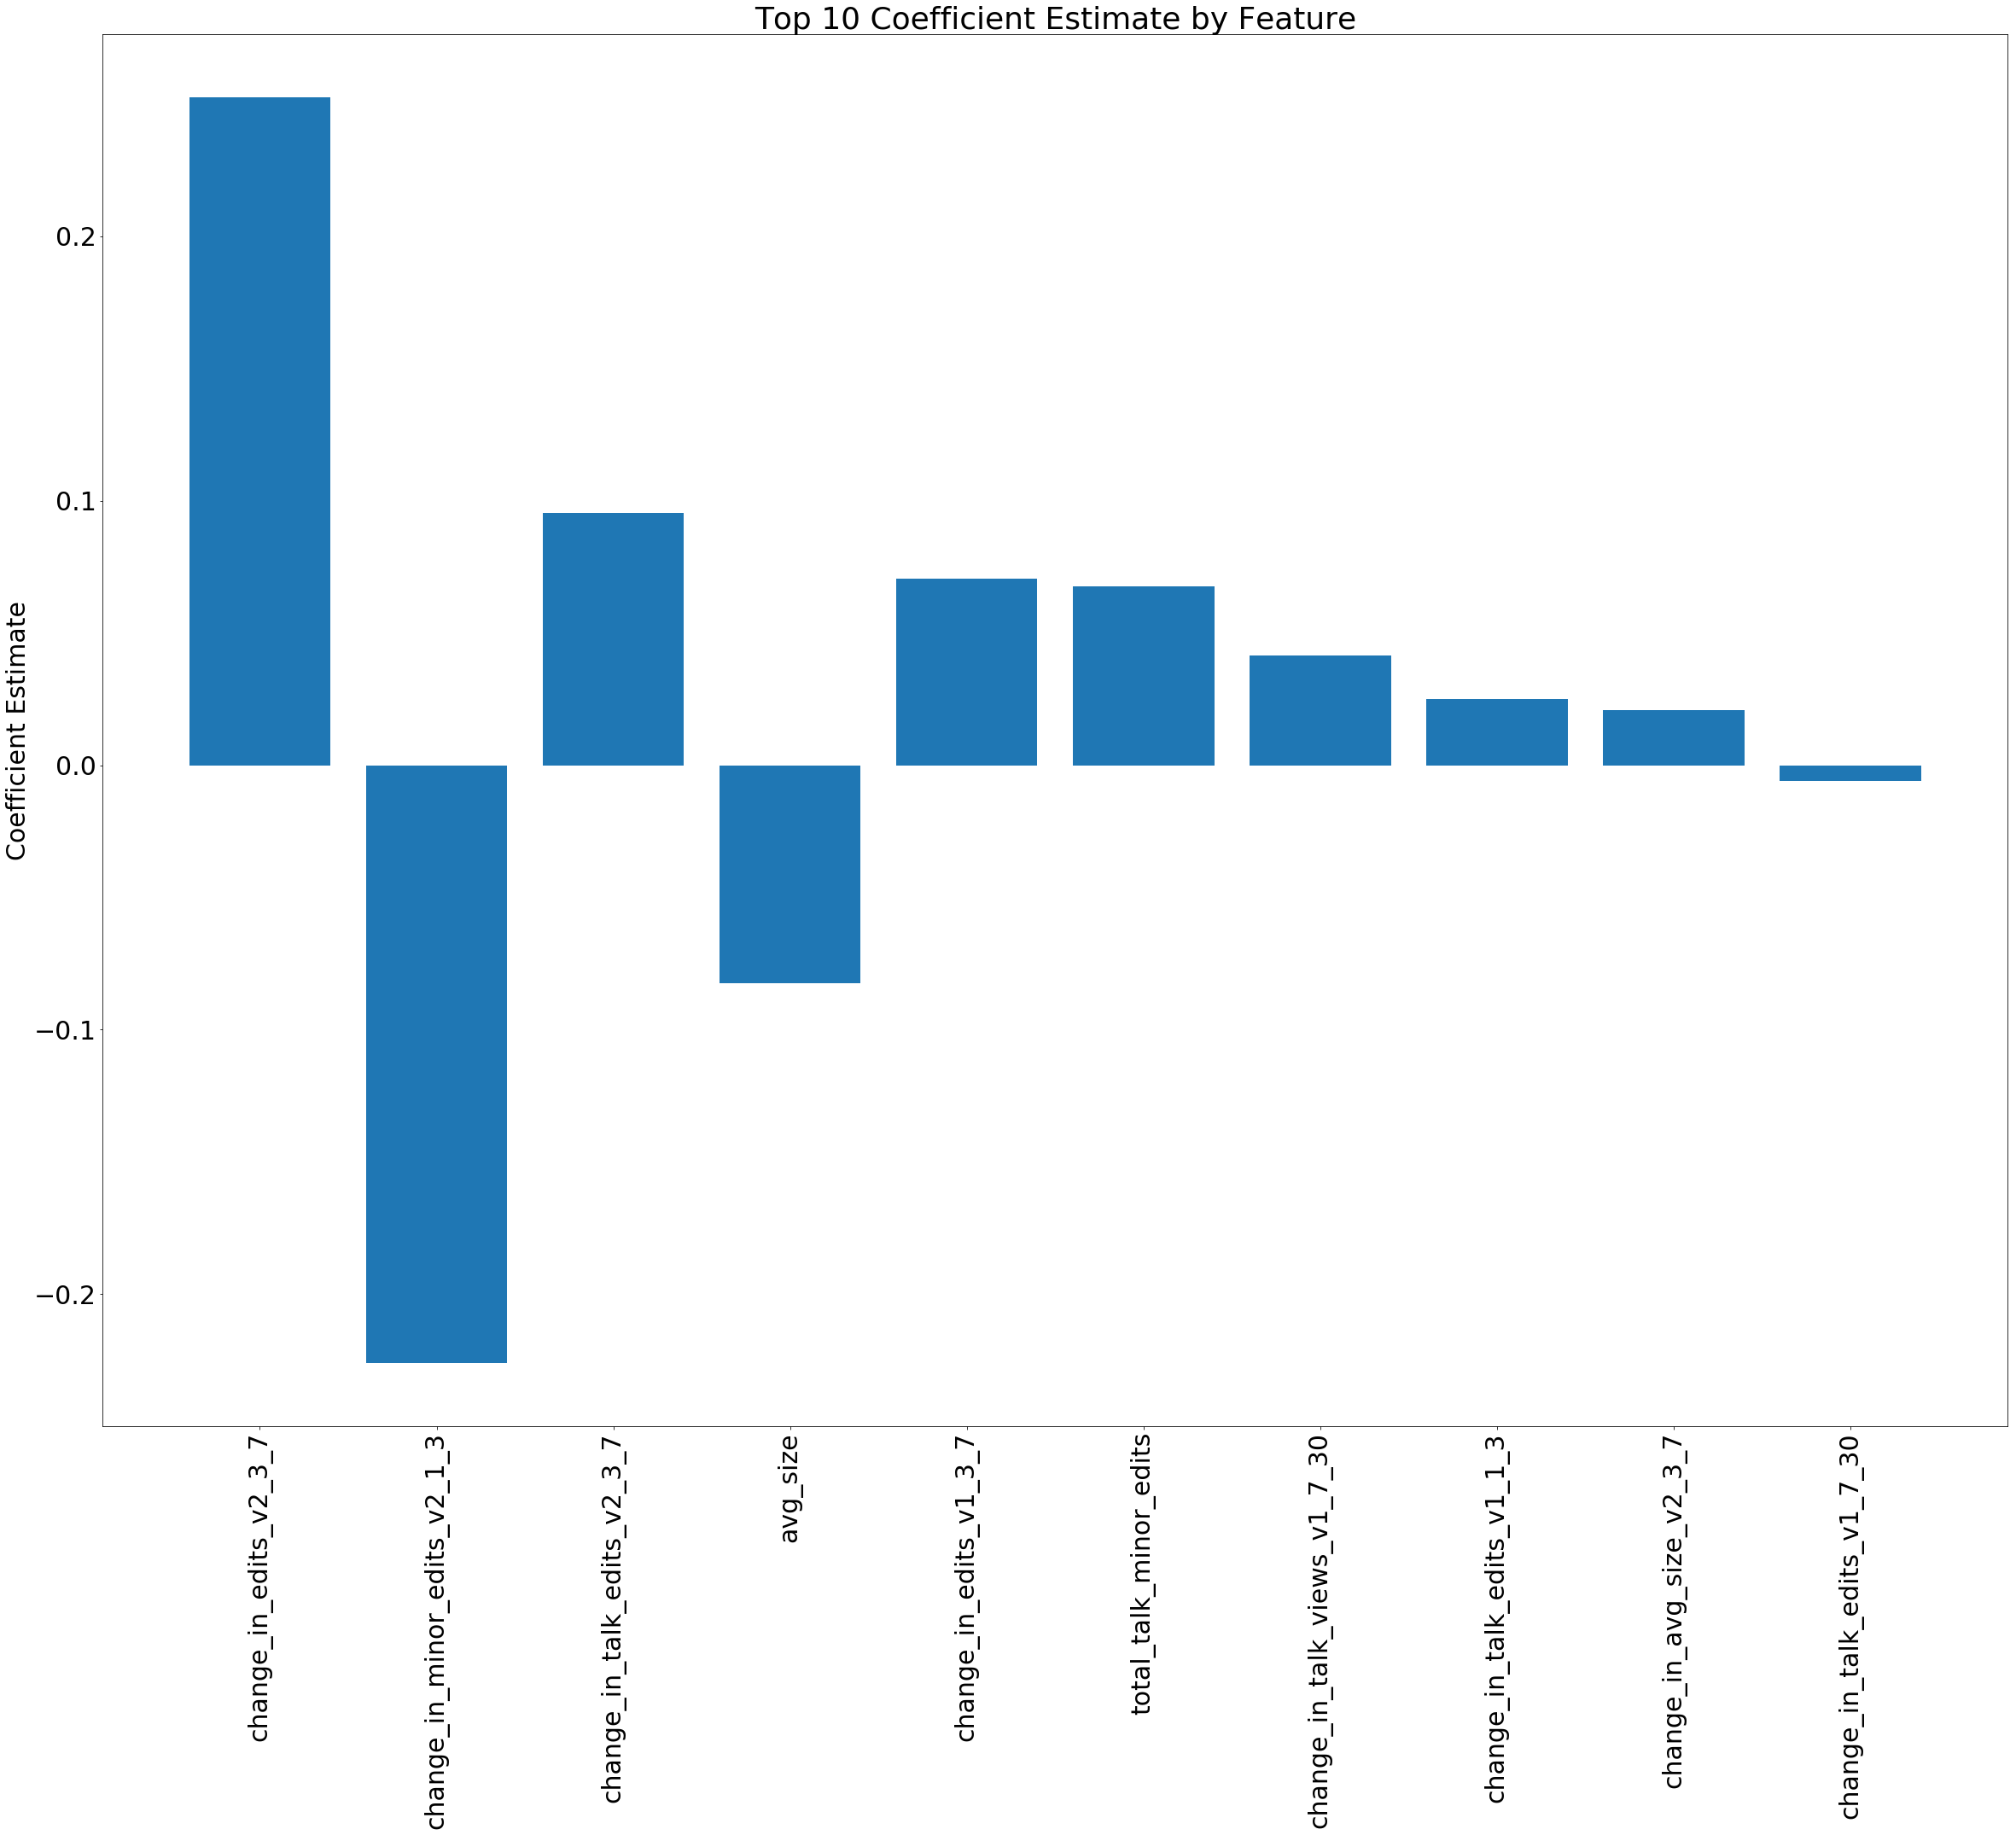

In [61]:
# LASSO

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

lasso_coefficients = lasso.coef_

ax = plt.gca()
_, sort_i = list(zip(*sorted(zip(np.abs(lasso_coefficients[0]), range(plot_lim)), reverse=True)))
sorted_coefs = [lasso_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

plt.bar(range(plot_lim), sorted_coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [ ]:
# K-nearest neighbors (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

np.random.seed(seed=13579)

knn = KNeighborsClassifier()

knn_features = features
knn_target = 'num_edits_binary'

old_vars = []

final_lst = []

while len(knn_features) > 0:
    one_run = []
    for feature in knn_features:
        one_run += [[np.mean(cross_val_score(knn, 
                                             df_b2_ri_n[old_vars + [feature]], 
                                             df_b2_ri_n[target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0], reverse=True)
    final_lst += [one_run[0]]
    old_vars += [one_run[0][1]]
    knn_features = [f for f in knn_features if f != one_run[0][1]]
    if len(final_lst) >= 2 and final_lst[-1][0] < final_lst[-2][0]:
        final_lst = final_lst[:-1]
        break

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Forward Selection")

plt.show()

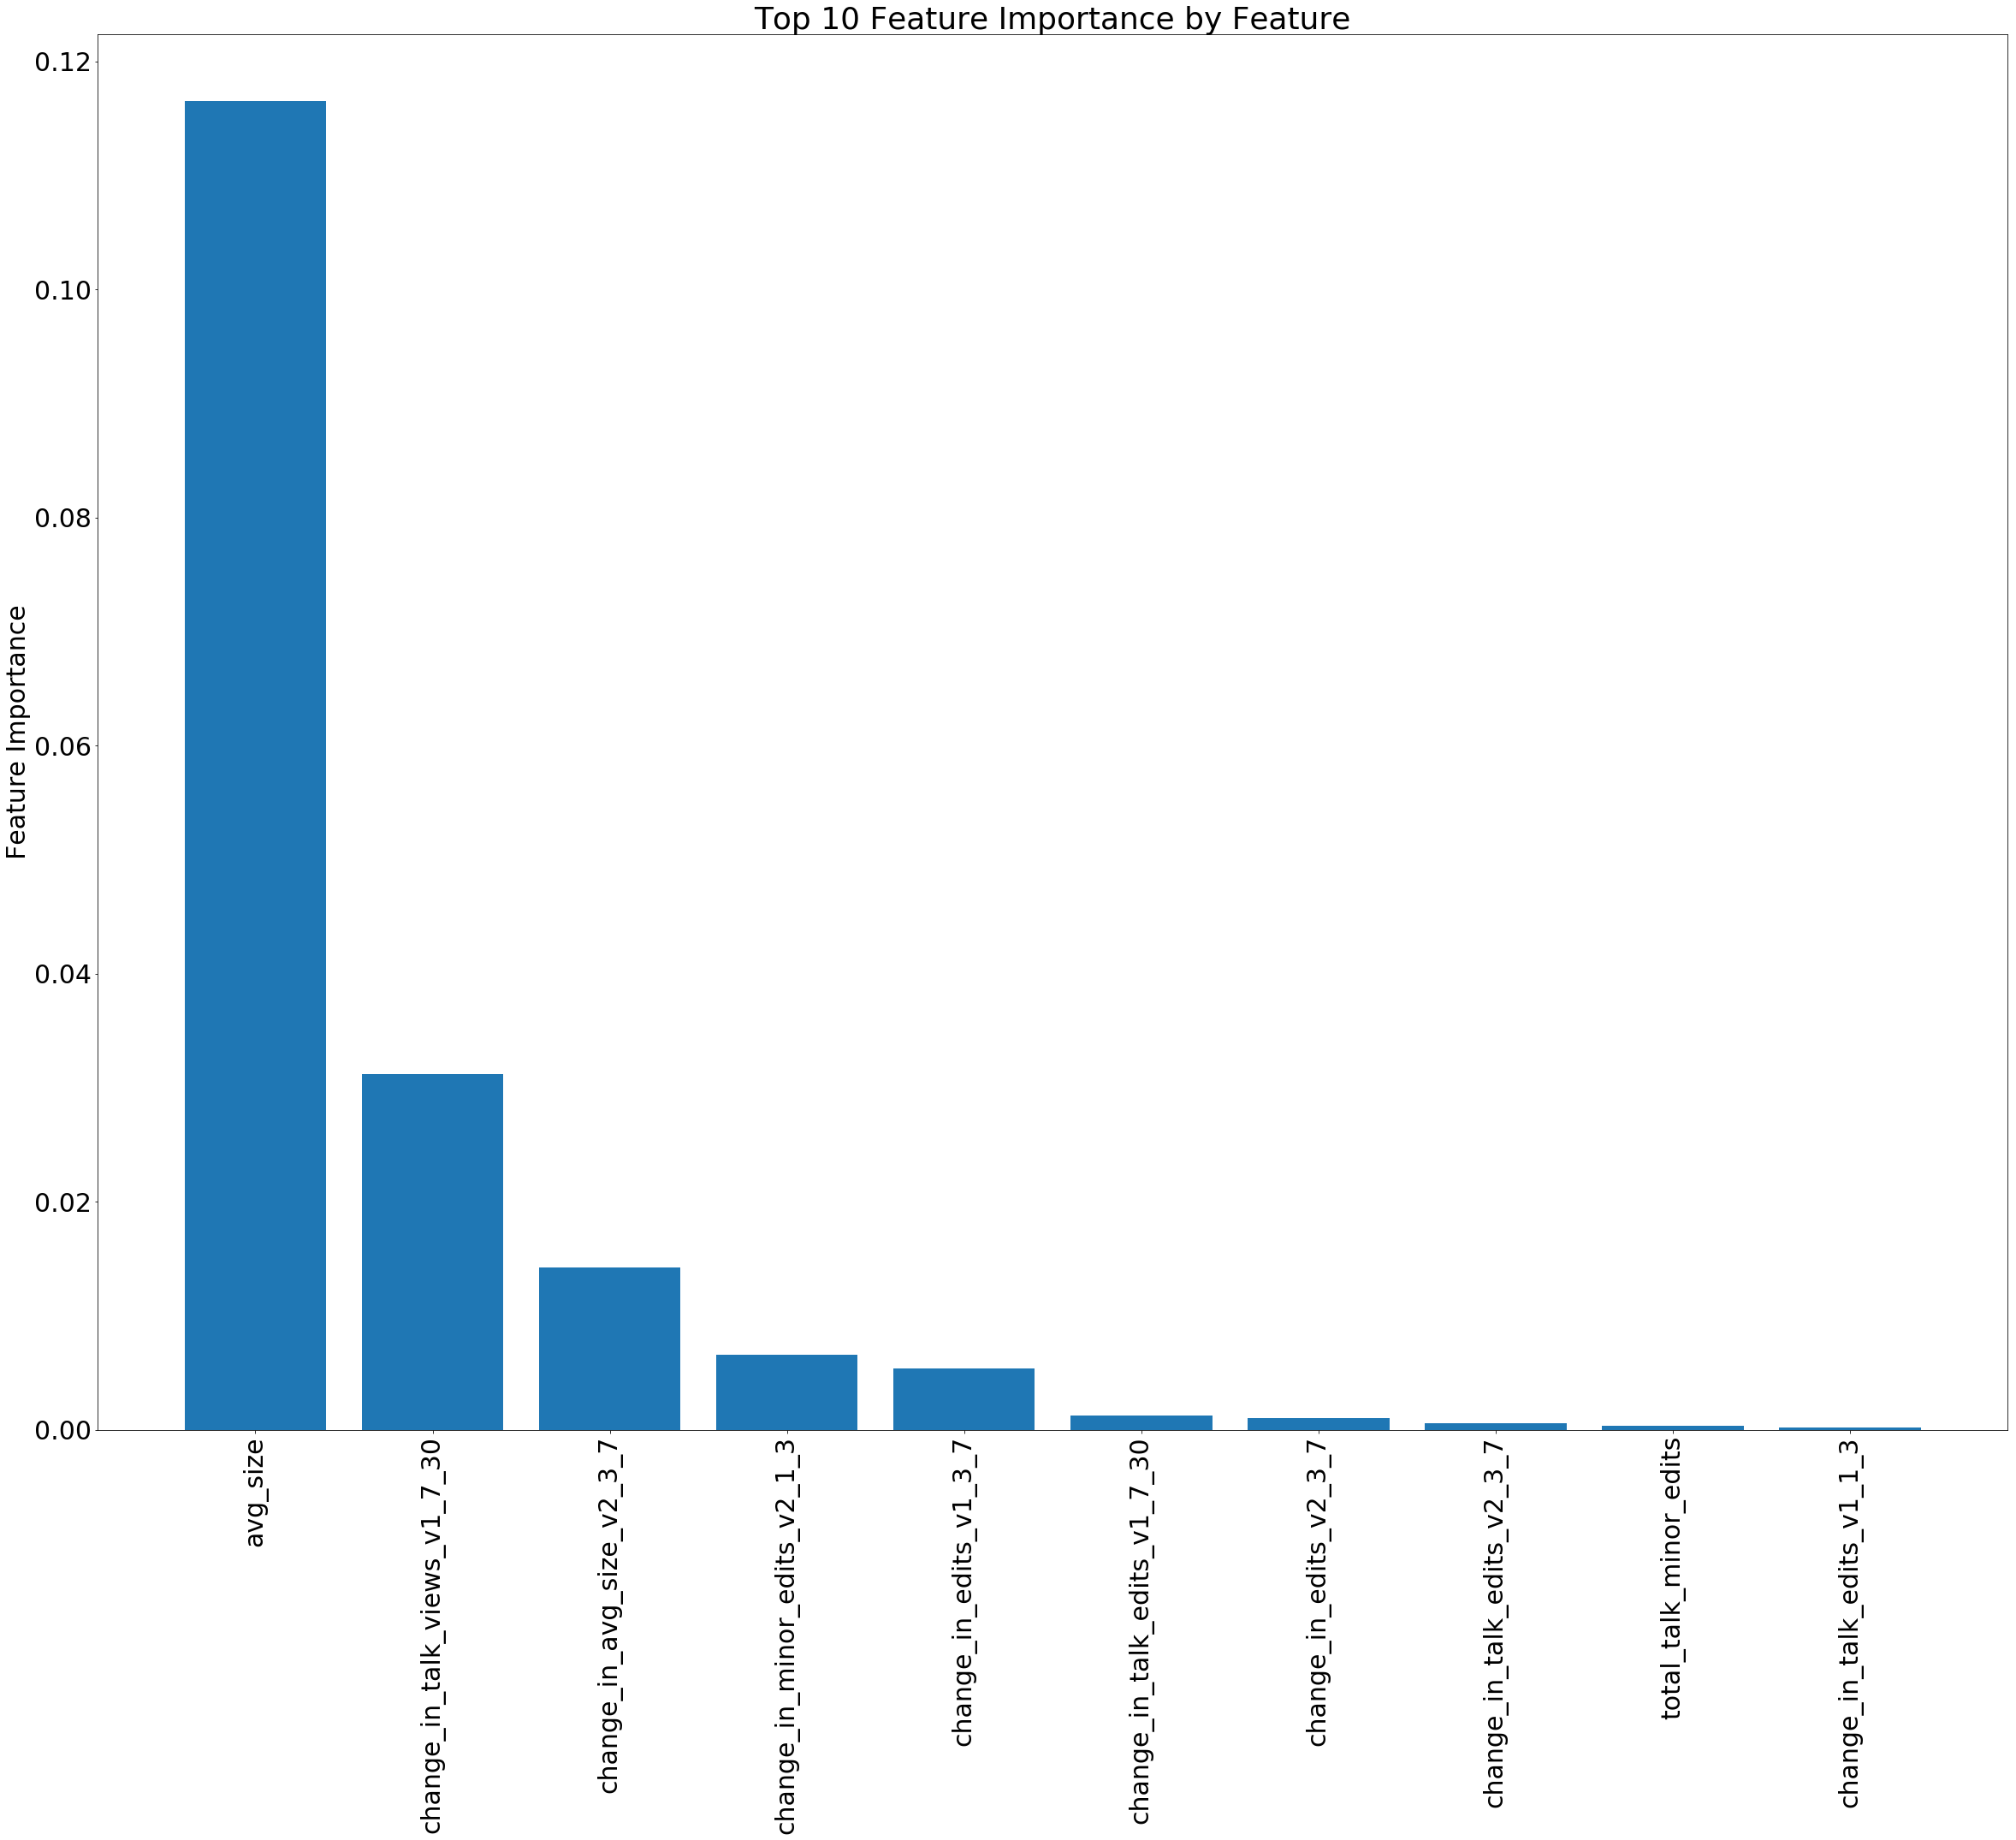

In [62]:
# Random forest

forest = RandomForestClassifier(random_state=13579)
forest.fit(train_x, train_y)

feature_importances = forest.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

ax = plt.gca()
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [ ]:
# Multi-layer perceptron (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

tron_features = features
tron_target = 'num_edits_binary'

final_lst = []

while len(tron_features) > 1:
    one_run = []
    for feature in tron_features:
        tron = MLPClassifier(solver='lbfgs', random_state=13579)
        one_run += [[np.mean(cross_val_score(tron, 
                                             df_b2_ri_n[list(set(tron_features) - set([feature]))], 
                                             df_b2_ri_n[tron_target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0])
    final_lst += [one_run[0]]
    tron_features = [f for f in tron_features if f != one_run[0][1]]
    print(tron_features)

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Backward Selection")

plt.show()

In [ ]:
# Gradient boosting

boost = GradientBoostingClassifier(random_state=13579)
boost.fit(train_x, train_y)

feature_importances = boost.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

ax = plt.gca()
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.show()

**Analisys**
* It seems like for different models, different features are more important. Very often, it is total_views, total_talk_views, total_edits, as well as avg_size and latest_size (but not for lasso and logistic regression). 

* We can try some dimensionality reduction technique, like principal component analysis (PCA) to see if it is possible to cut on the number of features without damage to explained variance.

In [167]:
from sklearn.decomposition import PCA

#we'll use Minka’s MLE to guess the dimensions

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [175]:
print("initial number of features: ", len(new_feature_names))

initial number of features:  50


In [176]:
print("after dimensionality resuction: ", pca.n_components_)

after dimensionality resuction:  49


The PCA results suggest that ~50 is the reasonable number of features for this data set. This is an expected result, since our data is not very sparse (sparsity is one use case for PCA), and 50 dimensions is not too much (high dimensionality - another use case). 

In [ ]:
# TBD LATER IF HAVE EXTRA TIME

# - Explore class weights
# - Explore different algorithms